# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [3]:
!pip install datasets

Импорт необходимых библиотек

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
# seaborn.set(palette='summer')

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части. 

In [7]:
dataset = datasets.load_dataset('ag_news')
dataset

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [8]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    proccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(proccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }
#         print(train_sample['text'][0], '\n', train_sample['label'][0])
        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [10]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2500)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [11]:
def evaluate(model, eval_dataloader, number_show_messages=0) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    texts = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
            texts.extend(batch['input_ids'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    if number_show_messages > 0:
        print(f"Example of predictions:")
        for i in range(min(number_show_messages, len(target))):
            print(f"Text: {dataset['test'][i]['text']}")
            print(f"True Label: {target[i].item()}, Predicted Label: {predictions[i].item()}\n")
    
    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна. 

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие. 

In [12]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'mean'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [13]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import copy

def train(model, num_epochs=5, aggregation_type='mean', patience=2, l2=1e-6):
    # Метрики для сохранения данных
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=l2)
    
    # Ранняя остановка
    best_test_loss = float('inf')
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0  # Счетчик для остановки

    for epoch in range(num_epochs):
        # --- Тренировочная фаза ---
        model.train()
        epoch_train_losses = []
        for batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        # Сохранение среднего лосса для тренировочной выборки
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)

        # Оценка модели на обучающих данных
        train_accuracy = evaluate(model, train_dataloader)
        train_accuracies.append(train_accuracy)

        # --- Тестовая фаза ---
        model.eval()
        epoch_test_losses = []
        with torch.no_grad():
            for batch in eval_dataloader:
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                epoch_test_losses.append(loss.item())

        # Сохранение среднего лосса для тестовой выборки
        avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
        test_losses.append(avg_test_loss)

        # Оценка модели на тестовых данных
        test_accuracy = evaluate(model, eval_dataloader)
        test_accuracies.append(test_accuracy)

        # Обновление графиков после каждой эпохи
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss', color='#ff0055', marker='o')
        plt.plot(test_losses, label='Test Loss', color='#00ff00', marker='o')
        plt.title('Losses')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.xlim(0, num_epochs-1)

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy', color='#ff0055', marker='o')
        plt.plot(test_accuracies, label='Test Accuracy', color='#00ff00', marker='o')
        plt.title('Accuracies')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.xlim(0, num_epochs-1)
        plt.ylim(0, 1)
        plt.yticks(np.arange(0, 1.025, 0.05))
        plt.show()
        
        # Ранняя остановка: проверка на улучшение лосса
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            best_acc = test_accuracies[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Ранняя остановка на эпохе {epoch}. Лосс на тестовой выборке не улучшался в течение {patience} эпох.")
            break

    # Восстановление лучших весов модели
    model.load_state_dict(best_model_wts)
    print(f"Best val loss: {best_test_loss}")
    print(f"Best val accuracy: {best_acc}")
    return train_losses, test_losses, train_accuracies, test_accuracies


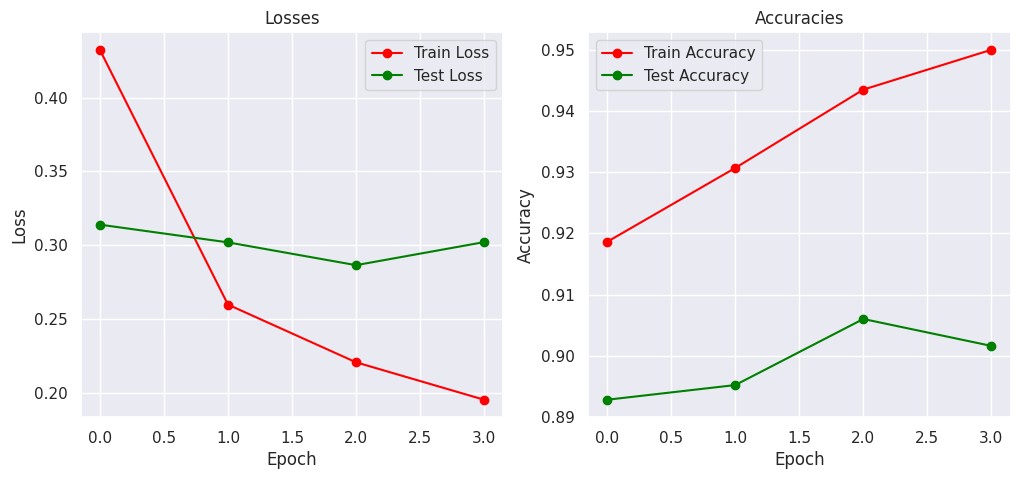

100%|██████████| 3750/3750 [01:21<00:00, 46.13it/s]


Ранняя остановка на эпохе 4. Лосс на тестовой выборке не улучшался в течение 2 эпох.


In [36]:
charlm_model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
charLM_train_losses, charLM_test_losses, charLM_train_accuracies, charLM_test_accuracies = train(charlm_model)

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно. 

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.

In [15]:
class CharLM_GRU(nn.Module):
    def __init__(self, hidden_dim, vocab_size, aggregation_type='mean', fc_layers=1, RNN_layers=1, dropout_rate=0):
        super(CharLM_GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.aggregation_type = aggregation_type
        
        self.network = nn.Sequential(
            nn.Embedding(vocab_size, hidden_dim),
            nn.GRU(hidden_dim, hidden_dim, num_layers=RNN_layers, batch_first=True),
            nn.Tanh(),
            nn.Dropout(p=dropout_rate)
        )
        
        fc_layers_list = []
        for _ in range(fc_layers):
            fc_layers_list.append(nn.Linear(hidden_dim, hidden_dim))
            fc_layers_list.append(nn.Tanh())
        fc_layers_list.append(nn.Linear(hidden_dim, vocab_size))
        self.fc_layers = nn.Sequential(*fc_layers_list)
        
    def forward(self, x):
        # Проход через Embedding и GRU
        embedded = self.network[0](x)
        gru_out, _ = self.network[1](embedded)
        
        # Агрегация по выбранному типу
        if self.aggregation_type == 'mean':
            aggregated = torch.mean(gru_out, dim=1)
        elif self.aggregation_type == 'max':
            aggregated, _ = torch.max(gru_out, dim=1)
        
        logits = self.fc_layers(aggregated)
        return logits


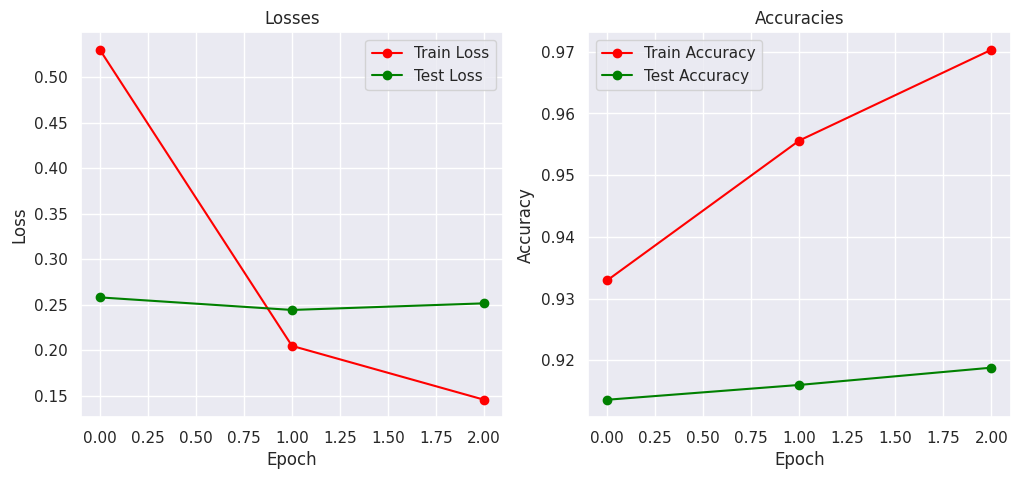

100%|██████████| 3750/3750 [01:32<00:00, 40.76it/s]


Ранняя остановка на эпохе 3. Лосс на тестовой выборке не улучшался в течение 2 эпох.


In [41]:
charlm_GRU_model = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab)).to(device)
_, gru_losses, _, gru_accs = train(charlm_GRU_model)

* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее. 

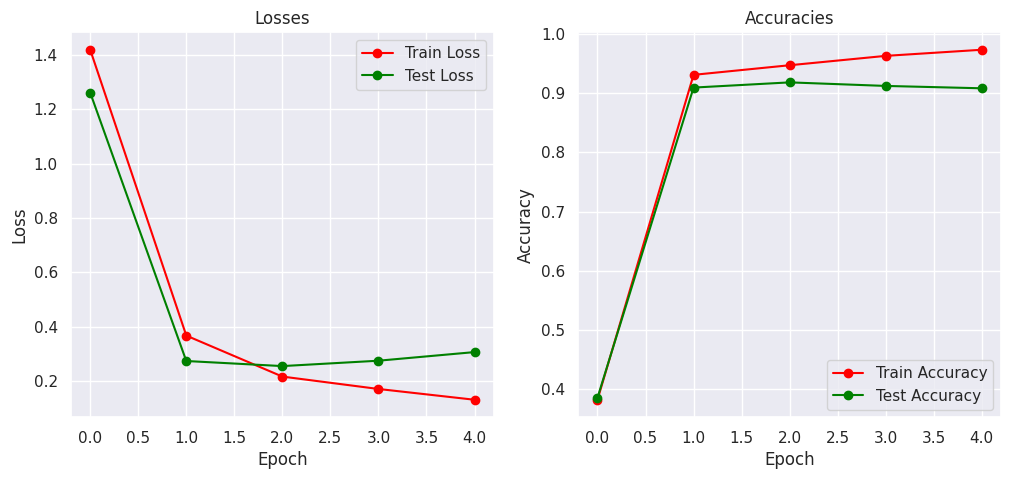

Ранняя остановка на эпохе 4. Лосс на тестовой выборке не улучшался в течение 2 эпох.


In [44]:
charlm_GRU_deep_model = CharLM_GRU(hidden_dim=256, RNN_layers=2, vocab_size=len(vocab)).to(device)
_, gru_deep_losses, _, gru_deep_accs = train(charlm_GRU_deep_model)

* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.

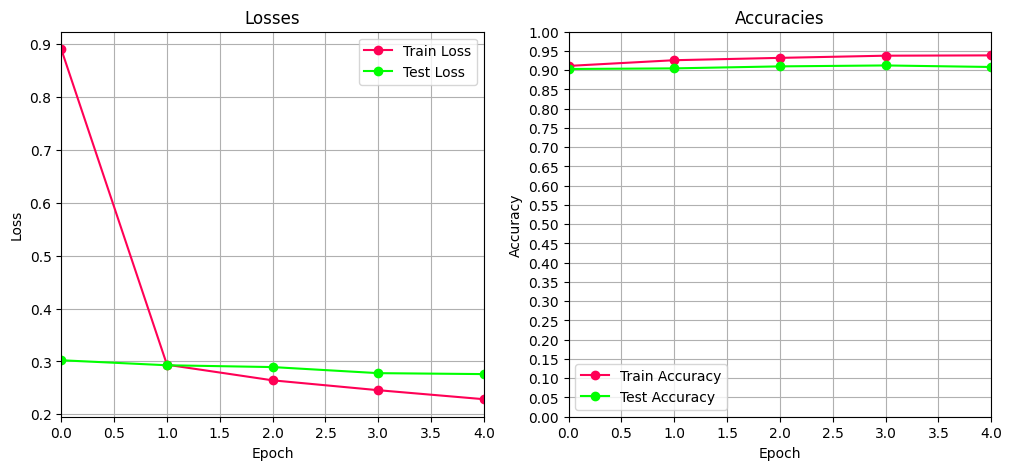

Best val loss: 0.27599347185909373
Best val accuracy: 0.9083999991416931


In [16]:
charlm_GRU_deeper_model = CharLM_GRU(hidden_dim=256, RNN_layers=2, fc_layers=2, vocab_size=len(vocab)).to(device)
_, gru_deeper_losses, _, gru_deeper_accs = train(charlm_GRU_deeper_model, l2=1e-4)

* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

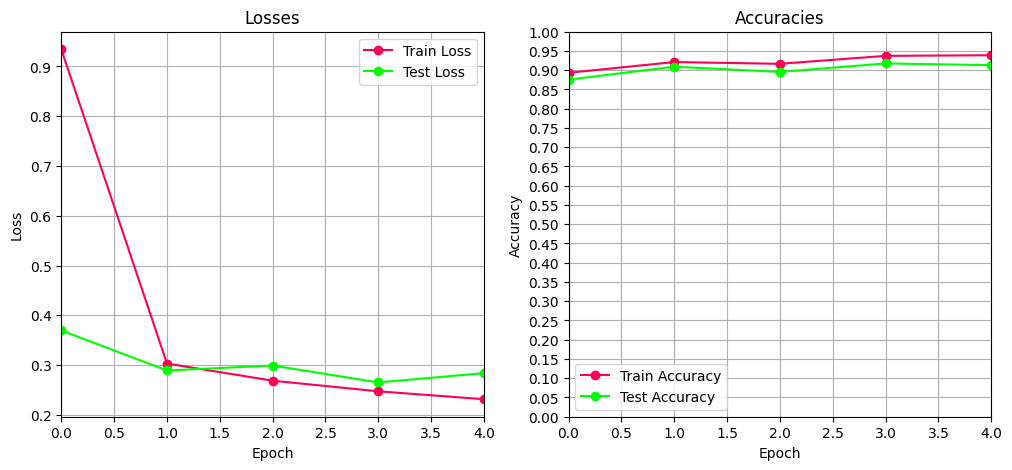

Best val loss: 0.2651289517201389
Best val accuracy: 0.9175999760627747


In [17]:
charlm_GRU_dropaut_model = CharLM_GRU(hidden_dim=256, RNN_layers=2, fc_layers=2, vocab_size=len(vocab), dropout_rate=0.2).to(device)
_, gru_deeper_losses, _, gru_deeper_accs = train(charlm_GRU_dropaut_model, l2=1e-4)

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству. 

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

In [55]:
best_accuracy = evaluate(charlm_GRU_model, eval_dataloader, number_show_messages=25)
print(best_accuracy)

Example of predictions:
Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
True Label: 3, Predicted Label: 3

Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
True Label: 0, Predicted Label: 0

Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
True Label: 3, Predicted Label: 3

Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his s

In [20]:
# print(evaluate(charlm_GRU_deep_model, eval_dataloader))
charlm_GRU_deeper_model
print(evaluate(charlm_GRU_deeper_model, eval_dataloader))
print(evaluate(charlm_GRU_dropaut_model, eval_dataloader))

0.9083999991416931
0.9175999760627747


### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты. 
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет. 
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная? 
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Отчет #
Итак, всего было проведено 5 экспериментов:
1. Первая модель из семинара сразу показал неплохой результат ~0.905. После третьей эпохи идет переобучение, причем l2 регуляризация не спасает.
2. Во второй моделе RNN блок был заменен GRU блоком, на второй эпохе мы получили наименьший лосс, и accuracy 0.9159999. Забавно что на третьей эпохе прои большем валидационном лоссе полилась большая точность, возможно если бы не early stopping с окном в 2 эпохи, то результаты были бы еще выше.
3. В третьем эксперименте у GRU было два слоя вместо одного, примерно та же точность как и во втором эксперименте, в общем можем сделать вывод, что углублять GRU в данной задаче не имеет смысла.
4. В четвертом эксперименте было увеличено количество скрытых fc слоев с одного до двух, что не дало прироста и опять-таки получили примерно тот же результат.
5. В пятом эксперименте добавил dropout = 0.2 и получил самый высокий результат: 0.9176, но думаю 0.002 не такая большая разница относительно модели с однослойный GRU и одним скрытым fc слоем. Но воможно все-таки дропаут где-то зарешал и уменьшил переобучение.

Архитект